# Dataset creation
First we import the spotipy library to easily interface with the Spotify API, and <b>get the saved tracks</b>

In [60]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
client_id = 'data'
client_secret = 'data'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                                           client_secret=client_secret,
                                                           redirect_uri="http://localhost:8888/callback",
                                                           scope="user-library-read"))

def enumerate_genre(genres):
    genre_dict = { 1: 'country', 2: 'trap',3:'edm', 4:'pop', 5: 'indie', 6: 'metal', 7: 'rock', 8: 'hip-hop', 9: 'soul', 10: 'r&b',  11: 'jazz'}
    g=0
    for genre in genres:
        for key, value in genre_dict.items():
            if value in genre:
                g = key
        if g!=0:
            break
    return g

        

In [61]:


offset = 0
#get all saved tracks from spotify changing offset to get all tracks
numSongs=500
track_features = []
while True:
    results=sp.current_user_saved_tracks(limit=50,offset=offset)
    for item in results['items']:
        track = item['track']
        #get track supergenere from artist
        try:
            track_genres = sp.artist(track['artists'][0]['id'])['genres']
            g=enumerate_genre(track_genres)
            if(g==0):
                continue
        except:
            continue
        track_features.append(sp.audio_features(track['id']))
        #add column genre
        track_features[-1][0]['genre'] = g
    offset+=50
    if len(track_features)+50>=numSongs:
        break

#only get 150 random songs
import random
random.shuffle(track_features)
track_features = track_features[:150]

## Removed columns
- track links, IDs and similar metadata.
- Speechiness is redundant since we already have acousticness, and we also don't care about non-musical content (i.e. podcasts or audiobooks).
- Key is not useful since I don't have perfect pitch.
- Liveness since I don't really care if a song was recorded live or in studio (most of them are in studio anyway).
- Mode is reduntant since we have Valence, that best portrays the mood of the song (and the mode distribution is almost equiprobable).
- duration_ms is irrelevant since the vast majority of songs is in the 3-5 minutes range (and I really don't care about it)

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#convert all the features into a dataframe, NOT JUST THE FIRST
df=[]
for i in range(len(track_features)):
    df.append(pd.DataFrame(track_features[i]))
df = pd.concat(df)
df.drop(['type','id','uri','track_href','analysis_url','time_signature', 'key', 'mode', 'speechiness', 'liveness', 'duration_ms'],axis=1,inplace=True)
df['like']=1

In [63]:
df.head()

,danceability,energy,loudness,acousticness,instrumentalness,valence,tempo,genre,like
0,0.754,0.813,-5.400,0.071,0.00007,0.955,98.457,4,1
0,0.546,0.793,-5.753,0.334,0.37800,0.516,104.161,11,1
0,0.212,0.561,-14.217,0.800,0.00457,0.257,76.257,11,1
0,0.504,0.934,-6.802,0.536,0.84500,0.897,117.850,11,1
0,0.667,0.519,-14.370,0.329,0.42100,0.604,99.526,9,1


array([[<AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>,
        <AxesSubplot: title={'center': 'loudness'}>],
       [<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'valence'}>],
       [<AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'genre'}>,
        <AxesSubplot: title={'center': 'like'}>]], dtype=object)

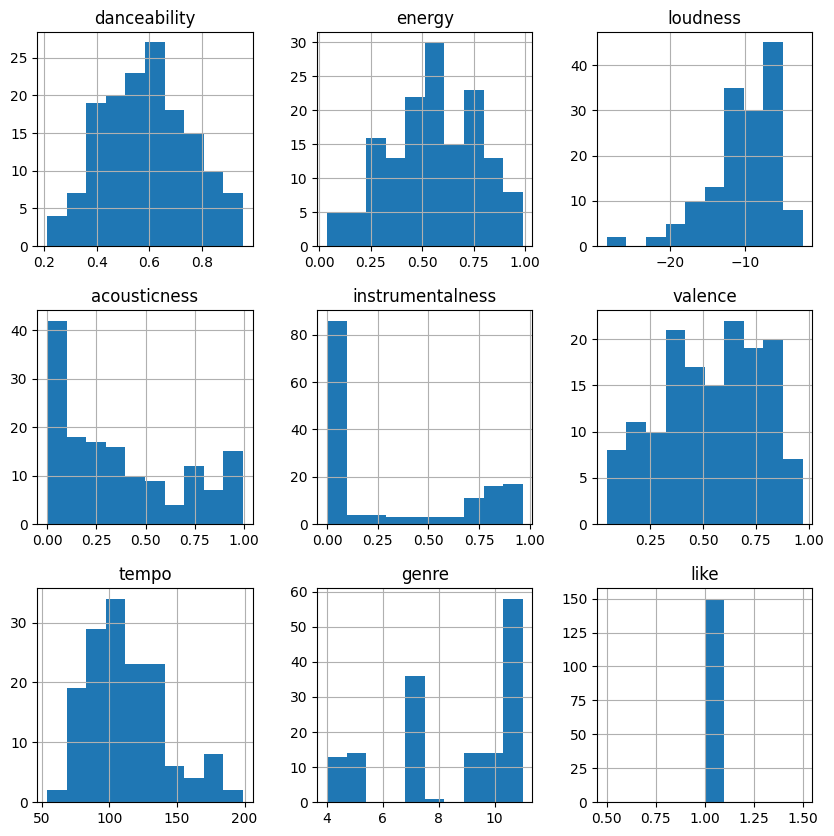

In [64]:
df.hist(figsize=(10,10))

By using correlation values and reasoning, i can create a custom model for the Bayesian network

<AxesSubplot: >

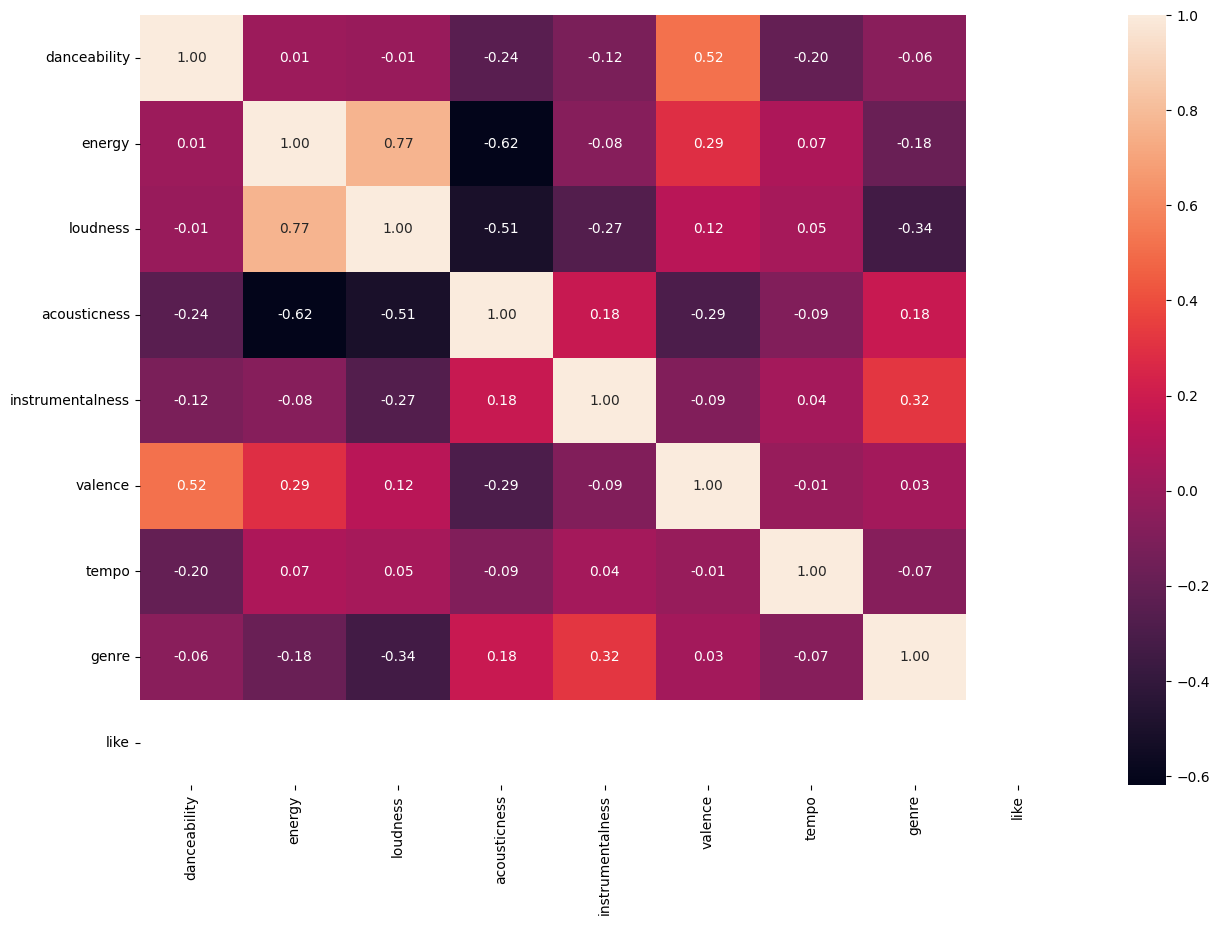

In [65]:
#show correlation between features
fig= plt.figure(figsize=(15,10))
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".2f")
            

<hr>


## Retrieve songs I dislike
I'll use:
- the top 50 charts of US, IT and UK with the (probably wrong) assumption that I dislike most of them (150 songs)
- an EDM playlist with >200 songs<br>
then I randomly sample only 150 of the total

In [66]:
top50=[]
linkPlaylistEDM='https://open.spotify.com/playlist/2e3dcRuo9uDH6qD3NOGKAL?si=cf3587f0d60647de'

#get top 50 songs in US, IT and UK
markets=['US', 'IT', 'UK']
for market in markets:
    results = sp.search(q='year:2022', type='track', limit=50, offset=0, market='US')
    #get features
    for i in range(len(results['tracks']['items'])):
        #get track supergenere from artist
        try:
            track_genre = sp.artist(results['tracks']['items'][i]['artists'][0]['id'])['genres']
            g=enumerate_genre(track_genre)
            if(g==0):
                continue
        except:
            continue
        top50.append(sp.audio_features(results['tracks']['items'][i]['id']))
        #add column genre
        top50[-1][0]['genre'] = g



In [67]:

#do same thing with playlist
offset=0
for i in range(2):
    #get tracks from link playlist
    results = sp.playlist_tracks(linkPlaylistEDM, limit=50, offset=offset)    
    for i in range(len(results['items'])):
        #get track supergenere from artist
        try:
            track_genre = sp.artist(results['items'][i]['track']['artists'][0]['id'])['genres']
            g=enumerate_genre(track_genre)
            #check if g is NaN
            if(g==0 or g==np.nan):
                continue
        except:
            continue
        audio_features = sp.audio_features(results['items'][i]['track']['id'])
        if(audio_features==[None]):
            continue
        top50.append(audio_features)
        #add column genre
        top50[-1][0]['genre'] = g
    offset+=50
    if offset>=results['total']:
        break
#convert to dataframe
#take only 150 random songs
random.shuffle(top50)
top50 = top50[:150]
dfDislike=[]
for i in range(len(top50)):
    dfDislike.append(pd.DataFrame(top50[i]))
dfDislike = pd.concat(dfDislike)
dfDislike.drop(['type','id','uri','track_href','analysis_url','time_signature', 'key', 'mode', 'speechiness', 'liveness', 'duration_ms'],axis=1,inplace=True)
#add column named 'like' with all 0s
dfDislike['like']=0


dfDislike.head()


,danceability,energy,loudness,acousticness,instrumentalness,valence,tempo,genre,like
0,0.838,0.525,-3.562,0.3450,0.000002,0.8840,144.981,4,0
0,0.746,0.896,-4.015,0.2460,0.000010,0.1330,125.939,4,0
0,0.728,0.894,-3.142,0.0928,0.000015,0.3920,126.074,4,0
0,0.682,0.882,-4.101,0.0288,0.201000,0.0485,125.049,3,0
0,0.700,0.550,-9.130,0.0661,0.000102,0.4120,164.003,4,0


array([[<AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>,
        <AxesSubplot: title={'center': 'loudness'}>],
       [<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'valence'}>],
       [<AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'genre'}>,
        <AxesSubplot: title={'center': 'like'}>]], dtype=object)

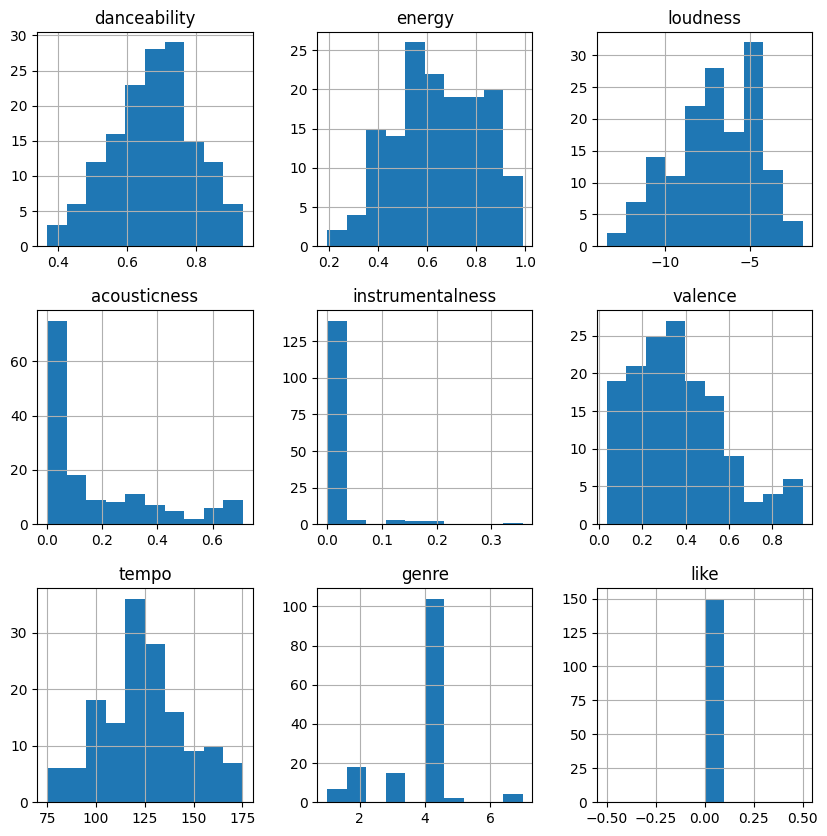

In [68]:
dfDislike.hist(figsize=(10,10))

<AxesSubplot: >

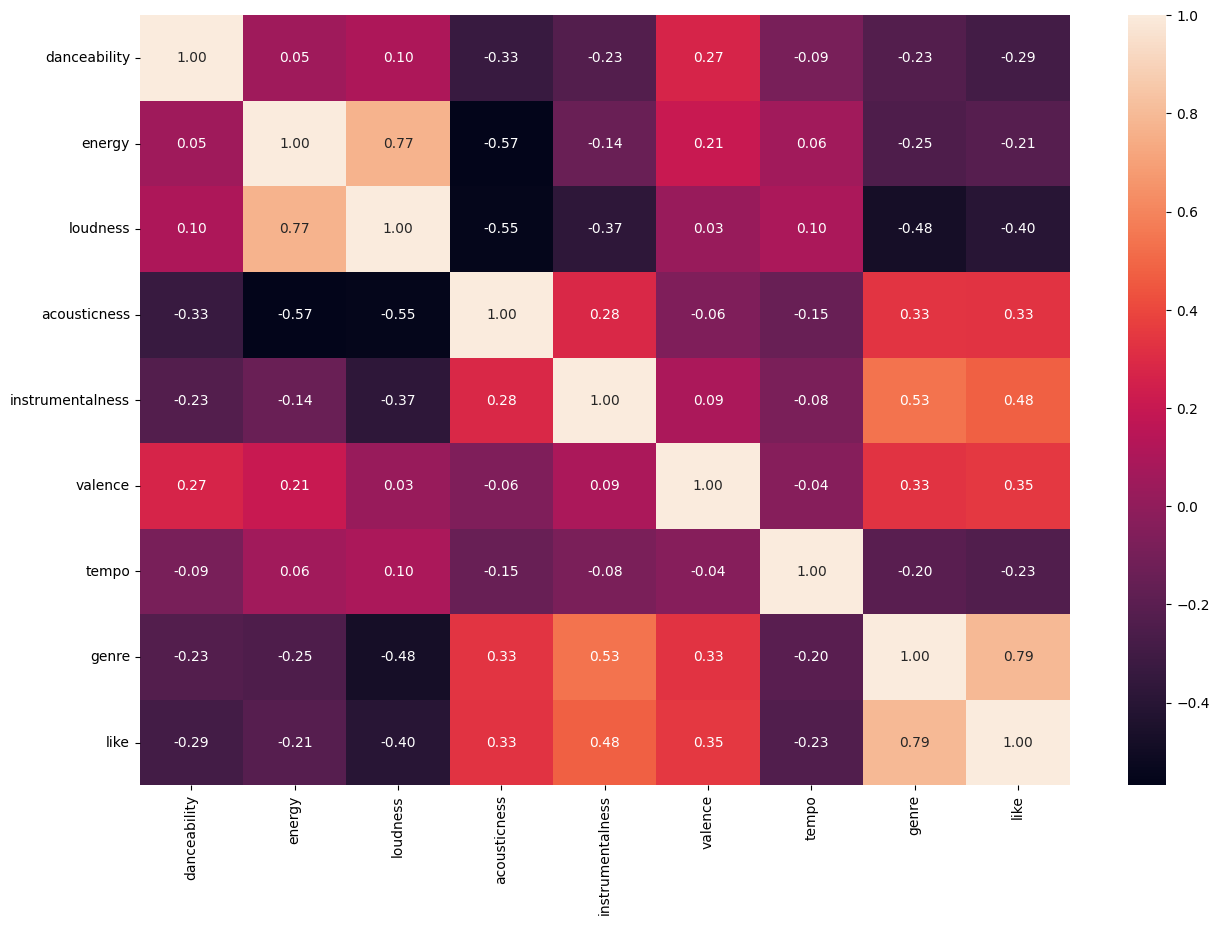

In [69]:
dfUnified=pd.concat([df,dfDislike])
fig= plt.figure(figsize=(15,10))
sns.heatmap(dfUnified.corr(),annot=True, fmt=".2f")

Save data in CSV file

In [70]:
dfUnified.to_csv('spotifyData.csv')

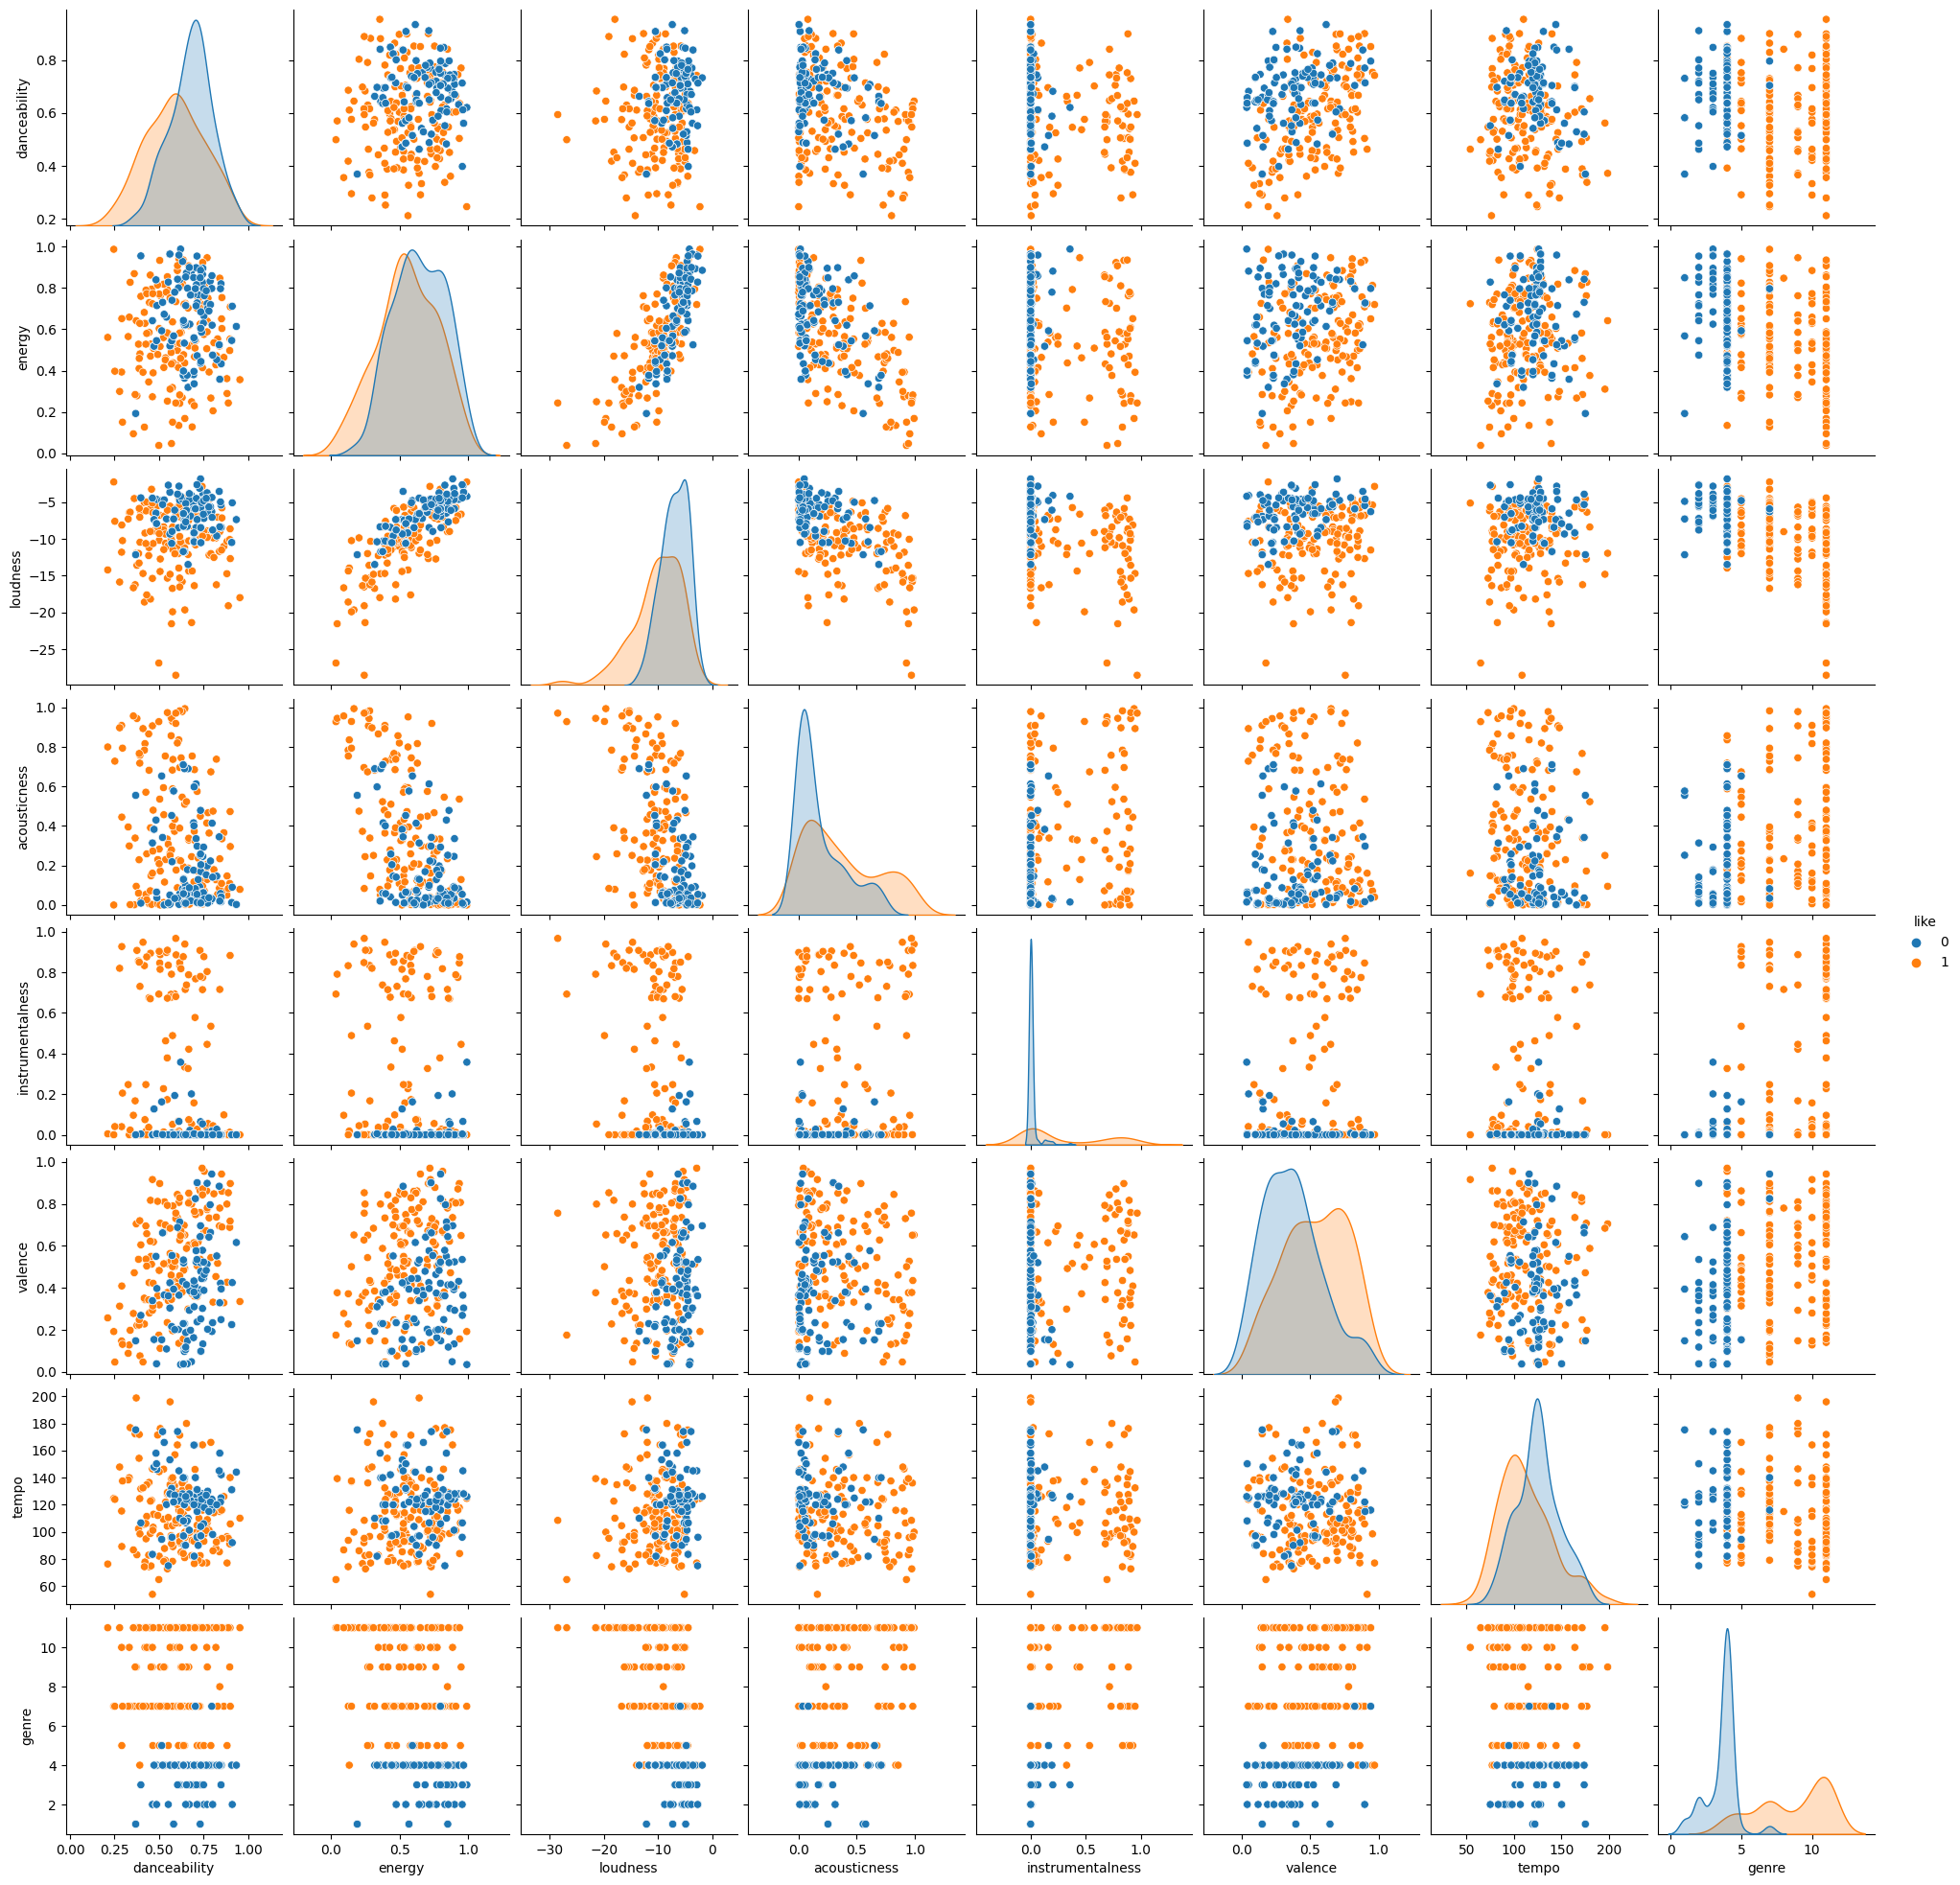

In [73]:
#pairplot
sns.pairplot(dfUnified, hue='like')

# References
- Spotify API documentation: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features 
- Similar project on Kaggle (but not with Bayesian networks): 